In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import syft as sy
import numpy as np
import torch as th
from syft import VirtualMachine
from pathlib import Path
from torchvision import datasets, transforms
from syft.core.plan.plan_builder import PLAN_BUILDER_VM, make_plan, build_plan_inputs, ROOT_CLIENT
from syft.lib.python.list import List
from matplotlib import pyplot as plt
from syft import logger
from syft.lib.torch.module import ModelExecutor
logger.remove()

In [3]:
# Dataset
mnist_path = Path.home() / ".pysyft" / "mnist"
mnist_path.mkdir(exist_ok=True, parents=True)

mnist_train = datasets.MNIST(str(mnist_path), train=True, download=True,
               transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

mnist_test = datasets.MNIST((mnist_path), train=False, 
              transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

train_loader = th.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True, pin_memory=True)
test_loader = th.utils.data.DataLoader(mnist_test, batch_size=1024, shuffle=True, pin_memory=True)

# define model


In [4]:
class ForwardToPlanConverter(type):
    def __call__(cls, *args, **kwargs):
        obj = type.__call__(cls, *args, **kwargs)
        obj.make_forward_plan()
        return obj

class SyModule(th.nn.Module, metaclass=ForwardToPlanConverter):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.building_forward = False
        self._parameter_pointers = dict()

    def make_forward_plan(self):
        if not hasattr(self, "forward"):
            raise ValueError("Missing .forward() method for Module")
        self.building_forward = True
        self.forward = make_plan(self.forward)
        self.building_forward = False
        
    def __getattr__(self, name):
        # this is __getattr__ instead of __getattribute__ because of the structure of torch.nn.Module
        if name in self._parameter_pointers and self.building_forward:
            return self._parameter_pointers[name]
        
        res = super().__getattr__(name)
        if isinstance(res, (th.nn.Module, th.nn.Parameter)) and self.building_forward:
            res_ptr = res.send(ROOT_CLIENT)
            self._parameter_pointers[name] = res_ptr
            return res_ptr
        else:
            return res

In [5]:
# class MySyModuleBlock(SyModule):
#     def __init__(self):
#         super().__init__()
#         self.p1 = th.nn.Parameter(th.rand(50,50))
#         self.relu1 = th.nn.ReLU()
#         self.l2 = th.nn.Linear(50,10)
    
#     def forward(self, x = th.rand(32, 50)):
#         o1 = x @ self.p1
#         relu_out = self.relu1(o1)
#         out = self.l2(relu_out)
#         return out

In [6]:
# class MySyModule(SyModule):
#     def __init__(self):
#         super().__init__()
#         self.layer1 = th.nn.Linear(28*28,50)
#         self.relu1 = th.nn.ReLU()
#         self.layer2 = MySyModuleBlock()
    
#     def forward(self, x = th.rand(32,28*28)):
#         x_reshaped = x.view(-1, 28 * 28)
#         o1 = self.layer1(x_reshaped)
#         a1 = self.relu1(o1)
#         out = self.layer2(x=a1)[0]
#         return out

In [7]:
class MySyModule(SyModule):
    def __init__(self):
        super().__init__()
        self.layer1 = th.nn.Linear(28*28,10)
    
    def forward(self, x = th.rand(32,28*28)):
        x_reshaped = x.view(-1, 28 * 28)
        o1 = self.layer1(x_reshaped)
        return o1

# Train plan

In [8]:
dummy_dl = sy.lib.python.List([
    [th.rand([32,1,28,28]), th.randint(0,10, (32,))] for _ in range(1)
])

In [9]:
remote_torch = ROOT_CLIENT.torch

In [10]:
def cross_entropy_loss(logits, targets, batch_size):
    norm_logits = logits - logits.max()
    log_probs = norm_logits - norm_logits.exp().sum(dim=1, keepdim=True).log()
    return -(targets * log_probs).sum() / batch_size


In [11]:
@make_plan
def train(dl = dummy_dl, model = MySyModule()):
#     loss_fn = remote_torch.nn.CrossEntropyLoss()
    optimizer = remote_torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0)

    for xy in dl:
#         optimizer.zero_grad()
        x, y = xy[0], xy[1]
        out = model.forward(x=x)[0]
        loss = remote_torch.nn.functional.nll_loss(out, y)
        loss.backward()
        optimizer.step()
    
    return [model]

In [12]:
alice_client = VirtualMachine(name="alice").get_client()
train_ptr = train.send(alice_client)

In [15]:
def test(test_loader, model):
    correct = []
    model.eval()
    for data, target in test_loader:
        output = model(x=data)[0]
        _, pred = th.max(output, 1)
        correct.append(th.sum(np.squeeze(pred.eq(target.data.view_as(pred)))))
    acc = sum(correct) / len(test_loader.dataset)
    return acc

In [16]:
def show_predictions(test_loader, model, n=6):
    xs, ys = next(iter(test_loader))
    preds = model(x=xs)[0].detach()
    
    fig, axs = plt.subplots(1, n, sharex='col', sharey='row', figsize=(16, 8))
    for i in range(n):
        ax = axs[i]
        ax.set_xticks([]),ax.set_yticks([])
        ax.set_xlabel(f"prediction: {np.argmax(preds[i])}, actual: {ys[i]}")
        ax.imshow(xs[i].reshape((28, 28)))

In [18]:
local_model = MySyModule()

/Users/koen/workspace/PySyft/src/syft/lib/torch/uppercase_tensor.py:30: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  grad = getattr(obj, "grad", None)


accuracy: 0.07


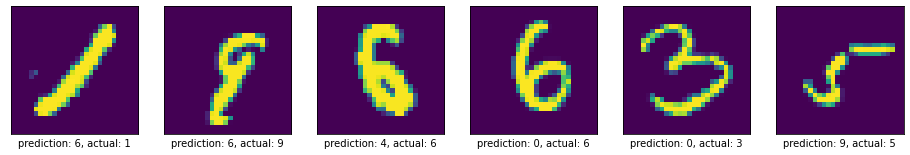

In [19]:
show_predictions(test_loader, local_model)
print(f"accuracy: {test(test_loader, local_model):.2F}")

# Train

In [42]:
print(list(local_model.parameters())[0].grad)

None


In [20]:
# res_ptr  = train_ptr(dl=dl, model=local_model)

In [21]:
# list(local_model.parameters())[0]

In [45]:
for i, (x, y) in enumerate(train_loader):
    dl = [[x,y]]
    res_ptr  = train_ptr(dl=dl, model=local_model)
#     local_model.zero_grad()
    local_model, = res_ptr.get()

    if i%10 == 0:
        print(list(local_model.parameters())[0].grad[0][240:250])
        print(list(local_model.parameters())[0][0][:5])
        acc = test(test_loader, local_model)
        print(f"Iter: {i} Test accuracy: {acc:.2F}", flush=True)
    if i>20:
        break

tensor([-0.1740, -0.1726, -0.1693, -0.1877, -0.2428, -0.1887, -0.1052, -0.0235,
         0.0398,  0.0398])
tensor([ 0.0099,  0.0087, -0.0077, -0.0034, -0.0293], grad_fn=<SliceBackward>)


/Users/koen/workspace/PySyft/src/syft/lib/torch/uppercase_tensor.py:30: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  grad = getattr(obj, "grad", None)


Iter: 0 Test accuracy: 0.34
tensor([-0.1740, -0.1726, -0.1693, -0.1877, -0.2428, -0.1887, -0.1052, -0.0235,
         0.0398,  0.0398])
tensor([-0.0299, -0.0311, -0.0475, -0.0432, -0.0691], grad_fn=<SliceBackward>)
Iter: 10 Test accuracy: 0.34
tensor([-0.1740, -0.1726, -0.1693, -0.1877, -0.2428, -0.1887, -0.1052, -0.0235,
         0.0398,  0.0398])
tensor([-0.0696, -0.0709, -0.0872, -0.0830, -0.1089], grad_fn=<SliceBackward>)
Iter: 20 Test accuracy: 0.34
